In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [95]:
import gdal
import os
import gdalio
from scipy.misc import imresize

In [112]:
np.sqrt( 200*200/(d1.RasterXSize*d1.RasterYSize) )

0.050830344874883068

In [172]:
d1 = gdal.Open("/home/artef/Maps/dubai_2016_2018_pair_2016.tiff")
d2 = gdal.Open("/home/artef/Maps/dubai_2016_2018_pair_2018.tiff")
desired_fraction = np.sqrt( 400*400/(d1.RasterXSize*d1.RasterYSize) )
img1 = d1.GetRasterBand(3).ReadAsArray()
img2 = d2.GetRasterBand(3).ReadAsArray()
common_area = (img1!=0)&(img2!=0)

In [186]:
# clip fraction
from scipy.misc import imresize

def get_optimal_clip(img1,img2):
    desired_fraction = np.sqrt( 400*400/(d1.RasterXSize*d1.RasterYSize) )
    img1_small = imresize( img1, desired_fraction, interp='nearest')
    img2_small = imresize( img2, desired_fraction, interp='nearest')
    
    # get map of common area
    common_area = (img1_small!=0)&(img2_small!=0)
    
    def optimal_clip_internal(common_area):
    
        max_area = 0
        final_x_clip_min = 0
        final_x_clip_max = 0
        final_y_clip_min = 0
        final_y_clip_max = 0
        for c_coef in np.linspace(0,0.5,20):
            x_clip_min = int(c_coef*common_area.shape[1])
            x_clip_max = int(common_area.shape[1]*(1-c_coef))

            if x_clip_min >= x_clip_max:
                continue

            area = common_area[:,x_clip_min:x_clip_max].copy().astype(np.float)
            y_min = area.min(axis=1)
            if y_min.max() == 0:
                continue

            y_clip_min = np.argmax( area.min(axis=1) )
            y_clip_max = area.shape[0]-np.argmax( area.min(axis=1)[::-1] )

            area[y_clip_min,:] += 0.5
            area[y_clip_max,:] += 0.5

            total_area = (y_clip_max-y_clip_min)*(x_clip_max-x_clip_min)/common_area.shape[0]/common_area.shape[1]

            if total_area > max_area:
                max_area = total_area

                final_x_clip_min = x_clip_min
                final_x_clip_max = x_clip_max
                final_y_clip_min = y_clip_min
                final_y_clip_max = y_clip_max
            
        return max_area,final_x_clip_min,final_x_clip_max,final_y_clip_min,final_y_clip_max
            
    max_area,final_x_clip_min,final_x_clip_max,final_y_clip_min,final_y_clip_max = optimal_clip_internal(common_area)
    
    # check if transposed gives better result
    res2 = optimal_clip_internal(common_area.T)
    if res2[0] > max_area:
        max_area,final_y_clip_min,final_y_clip_max,final_x_clip_min,final_x_clip_max = res2
        
    # map everything back to original image
    final_y_clip_min = int(np.ceil(final_y_clip_min/common_area.shape[0]*img1.shape[0]))
    final_y_clip_max = int(np.floor(final_y_clip_max/common_area.shape[0]*img1.shape[0]))
    final_x_clip_min = int(np.ceil(final_x_clip_min/common_area.shape[1]*img1.shape[1]))
    final_x_clip_max = int(np.floor(final_x_clip_max/common_area.shape[1]*img1.shape[1]))
    
    return final_x_clip_min,final_x_clip_max,final_y_clip_min,final_y_clip_max


In [200]:
xmin,xmax,ymin,ymax = get_optimal_clip(img1!=0,img2!=0)

In [199]:
img1=img1.T
img2=img2.T

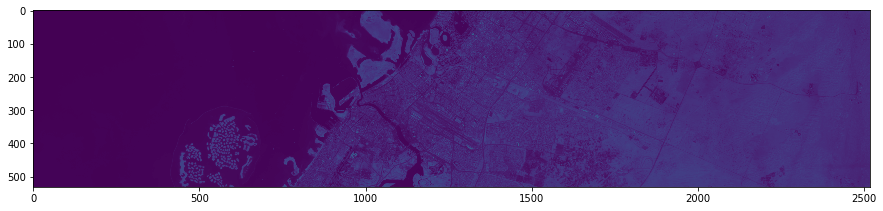

In [201]:
imshow( img1[ymin:ymax,xmin:xmax] );

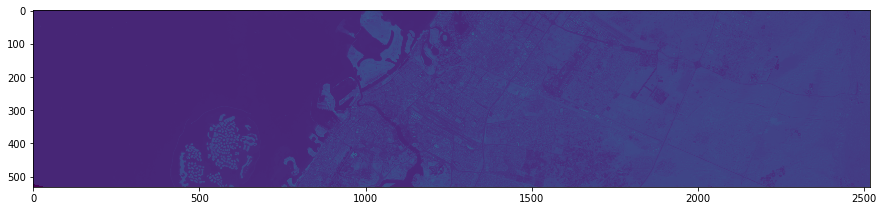

In [202]:
imshow( img2[ymin:ymax,xmin:xmax] );

# Search inscribed rectangle with largest area

In [75]:
band_r = ds.GetRasterBand(4)
band_g = ds.GetRasterBand(3)
band_b = ds.GetRasterBand(2)

In [80]:
window_size = np.array([1000,1000]).astype(np.int)
window_offset = ((np.array([rb.YSize,rb.XSize]) - window_size)/2 ).astype(int)
img = np.concatenate( (band_r.ReadAsArray(int(window_offset[1]),int(window_offset[0]),int(window_size[1]),int(window_size[0]))[:,:,np.newaxis],
    band_g.ReadAsArray(int(window_offset[1]),int(window_offset[0]),int(window_size[1]),int(window_size[0]))[:,:,np.newaxis],
    band_b.ReadAsArray(int(window_offset[1]),int(window_offset[0]),int(window_size[1]),int(window_size[0]))[:,:,np.newaxis]),axis=2)

p_min = np.percentile(img,1,axis=(0,1)).min()
p_max = np.percentile(img,99,axis=(0,1)).max()

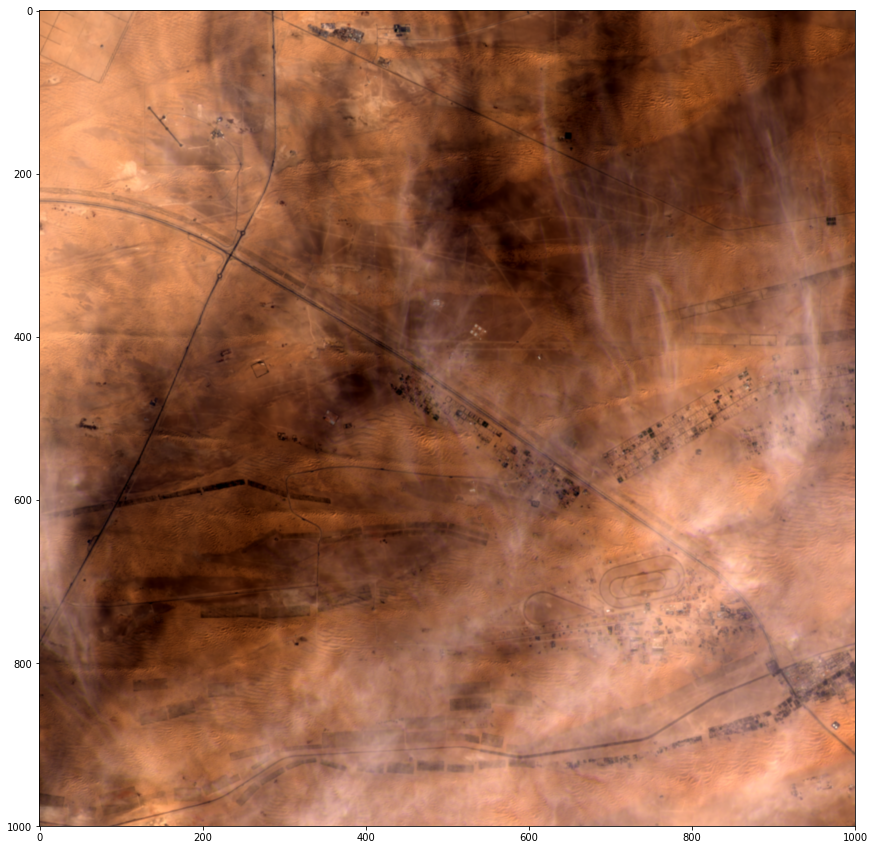

In [81]:
figsize(15,15)
imshow(normalize(img,p_min,p_max),interpolation='bicubic');